In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
from skimage import color

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def crop_img(img, new_shape):
    if (new_shape[-1] % 2 == 0):
        l_w = int((img.shape[-1] - new_shape[-1]) / 2)
        u_w = int((img.shape[-1] + new_shape[-1]) / 2)
        l_h = int((img.shape[-2] - new_shape[-2]) / 2)
        u_h = int((img.shape[-2] + new_shape[-2]) / 2)
    else:
        l_w = int((img.shape[-1] - new_shape[-1]) / 2) + 1
        u_w = int((img.shape[-1] + new_shape[-1]) / 2) + 1
        l_h = int((img.shape[-2] - new_shape[-2]) / 2) + 1
        u_h = int((img.shape[-2] + new_shape[-2]) / 2) + 1
    cropped_image = img[:, :, l_h:u_h, l_w:u_w]
    return cropped_image

In [4]:
def show_tensor_images(image_tensor, size=(3, 256, 256), num_images=8):
    image_flattened = image_tensor.detach().cpu().view(-1, *size)
    grid = make_grid(image_flattened[:num_images], nrow=4)
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
dataloader = DataLoader('train/', batch_size=4, shuffle=True)

In [6]:
class ImageData(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [7]:
images = ImageData('train', transforms.ToTensor())

In [8]:
train_loader = DataLoader(images, batch_size=4, shuffle=True)

# Define torch model components

### Unet

In [9]:
class CompressingBlock(nn.Module):
    def __init__(self, input_channels, batch_norm = True, dropout = False):
        super(CompressingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, (input_channels*2), kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d((input_channels*2), (input_channels*2), kernel_size=3, padding = 1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.use_batch_norm = batch_norm
        self.use_dropout = dropout
        if batch_norm:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        if dropout:
            self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x
    
    
    

In [10]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, batch_norm = True, dropout = False, inject_noise = False):
        super(ExpandingBlock, self).__init__()
        
        self.upsample2x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, int(input_channels/2), kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, int(input_channels/2), kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(int(input_channels/2), int(input_channels/2), kernel_size=2, padding = 1)
        self.relu = nn.ReLU()
        self.use_batch_norm = batch_norm
        self.use_dropout = dropout
        self.use_noise = inject_noise
        if batch_norm:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        if dropout:
            self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, res):
        x = self.upsample2x(x)
        x = self.conv1(x)
        if self.use_noise:
            x = torch.add(x,(torch.randn(x.shape, device=x.device) * 0.05))
        res = crop_img(res, x.shape)
        x = torch.cat([x, res], axis=1)
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        return x

In [11]:
class FeatureMap(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMap, self).__init__()
        
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
    
    def forward(self, x):
        
        x = self.conv(x)
        return x
        

In [12]:
class Unet(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(Unet, self).__init__()
        
        self.imToFeatures = FeatureMap(input_channels, hidden_channels)
        self.compress1 = CompressingBlock(hidden_channels, dropout=True)
        self.compress2 = CompressingBlock(hidden_channels * 2, dropout=True)
        self.compress3 = CompressingBlock(hidden_channels * 4)
        self.compress4 = CompressingBlock(hidden_channels * 8)
        self.compress5 = CompressingBlock(hidden_channels * 16)
        self.compress6 = CompressingBlock(hidden_channels * 32)
        self.compress7 = CompressingBlock(hidden_channels * 64)
        self.expand0 = ExpandingBlock(hidden_channels * 128, inject_noise=True)
        self.expand1 = ExpandingBlock(hidden_channels * 64)
        self.expand2 = ExpandingBlock(hidden_channels * 32)
        self.expand3 = ExpandingBlock(hidden_channels * 16)
        self.expand4 = ExpandingBlock(hidden_channels * 8)
        self.expand5 = ExpandingBlock(hidden_channels * 4)
        self.expand6 = ExpandingBlock(hidden_channels * 2)
        self.featuresToIm = FeatureMap(hidden_channels, output_channels)
        
    def forward(self, x):
        x0 = self.imToFeatures(x)
        x1 = self.compress1(x0)
        x2 = self.compress2(x1)
        x3 = self.compress3(x2)
        x4 = self.compress4(x3)
        x5 = self.compress5(x4)
        x6 = self.compress6(x5)
        x7 = self.compress7(x6)
        x8 = self.expand0(x7, x6)
        x9 = self.expand1(x8, x5)
        x10 = self.expand2(x9, x4)
        x11 = self.expand3(x10, x3)
        x12 = self.expand4(x11, x2)
        x13 = self.expand5(x12, x1)
        x14 = self.expand6(x13, x0)
        xn = self.featuresToIm(x14)
        return xn

### PatchGAN discriminator

In [13]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=8):
        super(PatchDiscriminator, self).__init__()
        self.imToFeatures = FeatureMap(input_channels, hidden_channels)
        self.compress1 = CompressingBlock(hidden_channels, batch_norm=False)
        self.compress2 = CompressingBlock(hidden_channels * 2)
        self.compress3 = CompressingBlock(hidden_channels * 4)
        self.compress4 = CompressingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.imToFeatures(x)
        x1 = self.compress1(x0)
        x2 = self.compress2(x1)
        x3 = self.compress3(x2)
        x4 = self.compress4(x3)
        xn = self.final(x4)
        return xn

# Training

In [14]:
gen = Unet(3, 3).to('cuda')
disc = PatchDiscriminator(3 + 3).to('cuda')
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0002)
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.0002)

In [15]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [16]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_loss_criterion, lambda_recon_loss):
    fake_imgs = gen(condition)
    fake_preds = disc(fake_imgs, real)
    adv_loss = adv_criterion(fake_preds, torch.ones_like(fake_preds))
    recon_loss = recon_loss_criterion(fake_imgs, real)
    gen_loss = adv_loss + lambda_recon_loss * recon_loss
    return gen_loss

In [17]:
def get_disc_loss(disc, fake, real, condition, adv_criterion):
    fake_preds = disc(fake, condition)
    real_preds = disc(real, condition)
    fake_loss = adv_criterion(fake_preds, torch.zeros_like(fake_preds))
    real_loss = adv_criterion(real_preds, torch.ones_like(real_preds))
    disc_loss = (fake_loss + real_loss) / 2
    return disc_loss

### Train Model Function

Epoch 0: Step 0


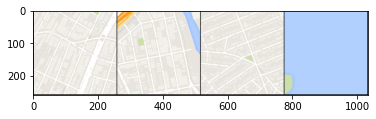

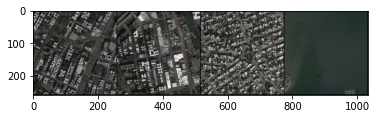

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


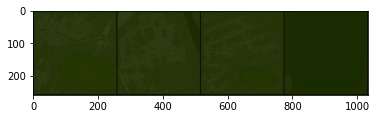

Epoch 0: Step 150


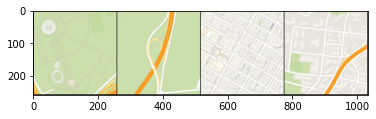

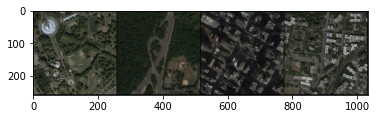

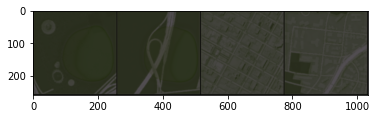

Epoch 1: Step 300


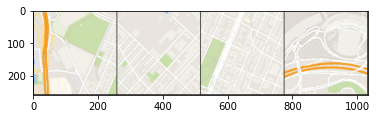

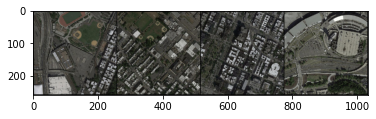

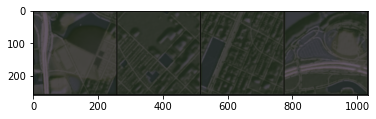

Epoch 1: Step 450


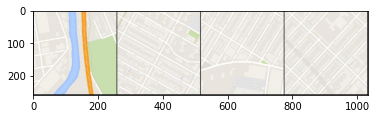

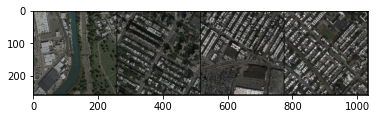

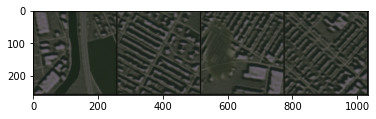

Epoch 2: Step 600


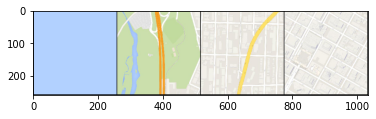

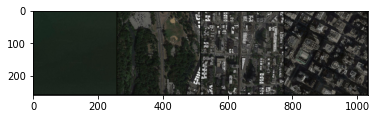

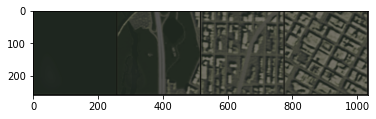

In [ ]:
def train_model(gen, disc, disc_opt, gen_opt, n_epochs = 30, adv_criterion=nn.BCEWithLogitsLoss(), recon_loss_criterion = nn.L1Loss(), lambda_recon_loss=200, dim=3, display_every=150, batch_size=4, target_shape=256, device='cuda', save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    
    cur_step = 0
    for epoch in range(n_epochs):
        for img in (tqdm(train_loader)):
            width = img.shape[3]
            inputs = img[:, :, :, width // 2:]
            inputs = nn.functional.interpolate(inputs, size=target_shape)
            real = img[:, :, :, :width // 2]
            real = nn.functional.interpolate(real, size=target_shape)
            inputs = inputs.to(device)
            real = real.to(device)
            
            #generate fakes
            with torch.no_grad():
                fake = gen(inputs)
            
            #update discriminator
            disc_opt.zero_grad()
            disc_loss = get_disc_loss(disc, fake.detach(), real, inputs, adv_criterion)
            disc_loss.backward(retain_graph=True)
            disc_opt.step()
            
            #update generator
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, inputs, adv_criterion, recon_loss_criterion, lambda_recon_loss)
            gen_loss.backward()
            gen_opt.step()
            
            #show every 
            if cur_step % display_every == 0:
                print(f"Epoch {epoch}: Step {cur_step}")
                show_tensor_images(inputs, size=(dim, target_shape, target_shape))
                show_tensor_images(real, size=(dim, target_shape, target_shape))
                show_tensor_images(fake, size=(dim, target_shape, target_shape))
                if save_model:
                        torch.save({'gen': gen.state_dict(),
                            'gen_opt': gen_opt.state_dict(),
                            'disc': disc.state_dict(),
                            'disc_opt': disc_opt.state_dict()
                        }, f"pix2pix_{cur_step}.pth")
            cur_step += 1

train_model(gen, disc, disc_opt, gen_opt)